In [1]:
import pandas as pd
# import modin.pandas as mpd
import numpy as np
import datetime
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
import mplfinance as mpf
from multiprocessing import Pool
from contextlib import contextmanager
from joblib import Parallel, delayed
from IPython.display import clear_output
# import dill as pickle
import pickle
import time

In [2]:
# causis api
from causis_api.const import get_version
from causis_api.const import login
login.username = 'shuai.song'
login.password = 'Tsinghua2022'
login.version = get_version()
from causis_api.data import *
from causis_api.tool import *

#### Stock Data Preparation
The strategy is executed on identical base positions. In this case, the base positions are components of CSI 500.

+ CST500 components weights

In [3]:
index_weights = pd.read_pickle('./dataset/tmp_position.pkl')

Arrange_dates = list(index_weights['df_t0_trade'].loc[index_weights['df_t0_trade']==False].index)
Arrange_dates.append(pd.to_datetime('2022-07-08 00:00:00'))

stock_weights = index_weights['df_pos'].transpose()

In [4]:
Weight_Matrix = index_weights['df_pos'].transpose()

for d in Weight_Matrix.columns:
    Weight_Matrix[d] = Weight_Matrix[d] / Weight_Matrix[d].sum()

Weight_Matrix = Weight_Matrix.transpose()

+ Data of the base positions (daily, min_bars, price & volumes needed) has been prepared and is stored in ./CST500_1min.pkl.

In [5]:
Base_Pos = pd.read_pickle('./dataset/CSI500_minute1.pkl')

+ Data Patches

In [6]:
new_patch = False

## Omitted symbols in Local Data (potential)
for id in tqdm(Weight_Matrix.columns, desc='Patching1'):
    if id not in Base_Pos.keys():
        df = get_price(id, '2019-11-29', '2022-07-08', 'minute1')
        if df.shape[0]:
            df = df.set_index('CLOCK', drop=False)
            Base_Pos[id] = df
            new_patch = True
        else:
            Base_Pos[id] = df
            new_patch = True

## Column 'CLOCK' Error 1 (potential)
for symbol in tqdm(Base_Pos.keys(), desc='Patching2'):
    if Base_Pos[symbol].shape[0]:
        if isinstance(Base_Pos[symbol]['CLOCK'][0], float):
            Base_Pos[symbol]['CLOCK'] = list(Base_Pos[symbol].index)
            new_patch = True

## Column 'CLOCK' Error 2 (potential)
for symbol in tqdm(Base_Pos.keys(), desc='Patching3'):
    if Base_Pos[symbol].shape[0]:
        if isinstance(Base_Pos[symbol]['CLOCK'][0], int):
            df = get_price(str(symbol), '2019-11-29', '2022-07-08', 'minute1')
            if df.shape[0]:
                df = df.set_index('CLOCK', drop=False)
                Base_Pos[symbol] = df
                new_patch = True

if new_patch:
    with open('./dataset/CSI500_minute1.pkl', 'wb') as f:
        pickle.dump(Base_Pos, f, pickle.HIGHEST_PROTOCOL)
    print("New Patch")

else:
    print("No New Patch")

Patching3: 100%|██████████| 774/774 [00:00<00:00, 96759.90it/s]

No New Patch


#### Global Environment Variables
+ Global Settings of Strategy and Backtest Environment

In [7]:
P_S_MA_WIN = 5
P_L_MA_WIN = 10

V_S_MA_WIN = 5
V_L_MA_WIN = 10

P_S_EMA_WIN = 12
P_L_EMA_WIN = 26

DEA_WIN = 9

H_MAX_WIN = 10
L_MIN_WIN = 10

FLUCT_TS = 0.01
ATR_WIN = 10

RECEPTIVE_WIN = 3
PROFIT_INTERRUPT_MUL = 1.0
LOSS_INTERRUPT_MUL = 0.0
REVERSE_MUL = 0.1

ACCOUNT = 1e6

COLORS = ['darkorange', 'cyan', 'royalblue', 'deeppink', 'indianred', 'limegreen']

#### Technical Features
+ Function *technical_analysis* calculates all the technical features we need, most important of which are 3 signals and fluctuations.
+ Function *tri_forks_filter* aggregates above four features and generates execution signals.

In [8]:
## Generate Position Open execution
def MACD_activation(_stmp, winsize):
    _stmp['rolling'] = list(_stmp.rolling(winsize))
    _stmp['execution'] = np.zeros(_stmp.shape[0])
    _stmp['pos_signal_count'] = _stmp['rolling'].apply(lambda x: x['signal1'].sum()) + _stmp['rolling'].apply(lambda x: x['signal3'].sum())
    _stmp['neg_signal_count'] = _stmp['rolling'].apply(lambda x: x['signal1'].sum()) + _stmp['rolling'].apply(lambda x: x['signal3'].sum())

    long_condition = (_stmp['pos_signal_count'] == 2) & (_stmp['Fluct'] > FLUCT_TS)
    short_condition = (_stmp['neg_signal_count'] == -2) & (_stmp['Fluct'] > FLUCT_TS)

    _stmp['execution'][long_condition] = 1
    _stmp['execution'][short_condition] = -1

    return _stmp['execution']

In [9]:
@contextmanager 
def timer(name: str, _align, _log): # ⏱
    s = time.time()
    yield
    elapsed = time.time() - s
    if _log:
        print(f"{ '[' + name + ']' :{_align}} | {time.strftime('%Y-%m-%d %H:%M:%S')} Done | Using {elapsed: .3f} seconds")

In [10]:
def technical_analysis(stmp, _activation, log = True):
    stmp = stmp.loc[~stmp['CLOCK'].duplicated()]
    
    with timer('BS_price & ATR', 25, log):
        ## Base Position Price
        stmp['BS_price'] = stmp['CLOSE'].shift(1)

        ## ATR
        _TR = [np.abs(stmp['HIGH'][0]-stmp['LOW'][0])]
        for i in range(1, stmp.shape[0]):
            _TR.append(max(np.abs(stmp['HIGH'][i]-stmp['LOW'][i]), np.abs(stmp['HIGH'][i]-stmp['CLOSE'][i-1]), np.abs(stmp['LOW'][i]-stmp['CLOSE'][i-1])))
        stmp['TR'] = _TR
        stmp['ATR'] = stmp['TR'].rolling(ATR_WIN).mean()

    with timer('Price Mean', 25, log):
        ## Price Mean
        stmp['P_L_MA'] = stmp['CLOSE'].rolling(P_L_MA_WIN).mean()
        stmp['P_S_MA'] = stmp['CLOSE'].rolling(P_S_MA_WIN).mean()
    
    with timer('Volume Mean', 25, log):
        ## Volume Mean
        stmp['V_L_MA'] = stmp['VOLUME'].rolling(V_L_MA_WIN).mean()
        stmp['V_S_MA'] = stmp['VOLUME'].rolling(V_S_MA_WIN).mean()

    with timer('MACD', 25, log):
        ## MACD
        stmp['DIF'] = stmp['CLOSE'].ewm(span=P_S_EMA_WIN, adjust=False).mean() - stmp['CLOSE'].ewm(span=P_L_EMA_WIN, adjust=False).mean()
        stmp['DEA'] = stmp['DIF'].ewm(span=DEA_WIN, adjust=False).mean()

    with timer('Channel', 25, log):
        ## Boundaries 
        stmp['H_max'] = stmp['HIGH'].rolling(H_MAX_WIN).max()
        stmp['L_min'] = stmp['LOW'].rolling(L_MIN_WIN).min()
    
    with timer('Fluctuation', 25, log):
        ## Fluctuation
        stmp['Fluct'] = (stmp['H_max'] - stmp['L_min'])/stmp['CLOSE']

    with timer('SIGNAL 1: Price Forks', 25, log):
        ## SIGNAL 1: Price Forks
        stmp['sign1'] = np.sign(stmp['P_S_MA'] - stmp['P_L_MA'])
        stmp['signal1'] = 2*stmp['sign1']/(2-np.abs(stmp['sign1']+stmp['sign1'].shift(1)))
        stmp['signal1'] = stmp['signal1'].replace([np.inf, -np.inf], np.nan)
        stmp['signal1'] = stmp['signal1'].fillna(0)

    with timer('SIGNAL 2: Volume Forks', 25, log):
        ## SIGNAL 2: Volume Forks
        stmp['sign2'] = np.sign(stmp['V_S_MA'] - stmp['V_L_MA'])
        stmp['signal2'] = 2*stmp['sign2']/(2-np.abs(stmp['sign2']+stmp['sign2'].shift(1)))
        stmp['signal2'] = stmp['signal2'].replace([np.inf, -np.inf], np.nan)
        stmp['signal2'] = stmp['signal2'].fillna(0)

    with timer('SIGNAL 3: MACD Forks', 25, log):
        ## SIGNAL 3: MACD Forks
        stmp['sign3'] = np.sign(stmp['DIF'] - stmp['DEA'])
        stmp['signal3'] = 2*stmp['sign3']/(2-np.abs(stmp['sign3']+stmp['sign3'].shift(1)))
        stmp['signal3'] = stmp['signal3'].replace([np.inf, -np.inf], np.nan)
        stmp['signal3'] = stmp['signal3'].fillna(0)

    with timer('Execution', 25, log):
        # Execution
        stmp['execution'] = _activation(stmp, RECEPTIVE_WIN)

    with timer('Volume Momentum', 25, log):
        time_curs = list(stmp.loc[stmp['execution']!=0]['CLOCK'])
        stmp['Vol_mom'] = np.zeros(stmp.shape[0])
        stmp['Vol_his_max'] = np.zeros(stmp.shape[0])
        for i in range(len(time_curs)-1):
            r_win = int((pd.to_datetime(time_curs[i+1]) - pd.to_datetime(time_curs[i])).total_seconds()/60)
            stmp['Vol_his_max'][time_curs[i]:time_curs[i+1]] = stmp.loc[time_curs[i]:time_curs[i+1]]['VOLUME'].rolling(r_win, min_periods=1).max().shift(1)
            stmp['Vol_his_max'][time_curs[i]] = stmp['VOLUME'][time_curs[i]]
            stmp['Vol_mom'][time_curs[i]:time_curs[i+1]] = np.sign(stmp.loc[time_curs[i]:time_curs[i+1]]['VOLUME'] - stmp['Vol_his_max'][time_curs[i]:time_curs[i+1]])
            stmp['Vol_mom'] = stmp['Vol_mom'].replace(-1, 0)

    return stmp

#### Strategy
+ Time to enter (i.e. open positions) has been decided in above features calculation.
+ Most operations in *basic_LS* are to decide when to close existing positions.

In [41]:
def basic_LS(_smp, account, _fees = True):
    _date = _smp['CLOCK'][0][:10]
    V1 = 100*int(((account/_smp['BS_price'][0])*0.1)/100)
    
    def solid_bar_time(_time):
        if (_date + ' 11:30:00' < _time) and (_time < _date + ' 13:00:00'):
            _time = str(pd.to_datetime(_time) + datetime.timedelta(hours=1, minutes=30))

        if _time == _date + ' 13:00:00':
            _time = str(pd.to_datetime(_time) + datetime.timedelta(minutes=1))
                    
        return _time

    pos_trading_points = _smp[:_date+' 14:55:00'].loc[(_smp['execution'] == 1)]['CLOCK'].to_list()
    neg_trading_points = _smp[:_date+' 14:55:00'].loc[(_smp['execution'] == -1)]['CLOCK'].to_list()

    _smp['Position'] = np.zeros(_smp.shape[0])
    _smp['close_reason'] = np.zeros(_smp.shape[0])

    ## Gains from positive forks
    pos_fork_gains = []
    last_close_buy_bar = _smp['CLOCK'][0]
    long_num = 0
    for t1 in pos_trading_points:
        open_buy_bar = solid_bar_time(str(pd.to_datetime(t1) + datetime.timedelta(minutes=1)))
        open_buy_price = _smp.loc[open_buy_bar]['OPEN']

        # at most 5 short executions
        if long_num > 5:
            break

        # Do not open again within 3 mins
        if open_buy_bar < str(pd.to_datetime(last_close_buy_bar) + datetime.timedelta(minutes=3)):
            continue

        # max holding period: inf min 
        for i in range (1, 1000): 
            buy_bar_ft = solid_bar_time(str(pd.to_datetime(open_buy_bar) + datetime.timedelta(minutes=i-1)))
            close_buy_bar = solid_bar_time(str(pd.to_datetime(open_buy_bar) + datetime.timedelta(minutes=i)))
            buy_bar_bt = solid_bar_time(str(pd.to_datetime(open_buy_bar) + datetime.timedelta(minutes=i+1)))
            last_close_buy_bar = close_buy_bar

            if close_buy_bar in pos_trading_points: # No appendant position
                del pos_trading_points[pos_trading_points.index(close_buy_bar)]

            # latest close time
            if close_buy_bar >= _date + ' 14:55:00':
                close_buy_bar = _date + ' 14:55:00'
                close_buy_price = _smp.loc[_date + ' 14:55:00']['OPEN']
                _smp['close_reason'][close_buy_bar] = 1 # close reason 1
                break

            # Trend Weaken interrupt
            if (_smp.loc[close_buy_bar]['signal3'] == -1.0):
                close_buy_bar = buy_bar_bt
                close_buy_price = _smp.loc[buy_bar_bt]['OPEN']
                _smp['close_reason'][close_buy_bar] = 2 # close reason 2
                break

            if _smp.loc[close_buy_bar]['Fluct'] <= FLUCT_TS:
                close_buy_bar = buy_bar_bt
                close_buy_price = _smp.loc[buy_bar_bt]['OPEN']
                _smp['close_reason'][close_buy_bar] = 3 # close reason 3
                break

            # Volume decrease interrupt
            if (_smp.loc[buy_bar_ft]['Vol_mom'] == 1.0) and (_smp.loc[close_buy_bar]['CLOSE']-_smp.loc[close_buy_bar]['OPEN'] < REVERSE_MUL*_smp.loc[close_buy_bar]['ATR']):
                close_buy_bar = buy_bar_bt
                close_buy_price = _smp.loc[buy_bar_bt]['OPEN']
                _smp['close_reason'][close_buy_bar] = 4 # close reason 4
                break

            # profit interrupt 
            if float(_smp.loc[close_buy_bar]['CLOSE']) >= _smp.loc[close_buy_bar]['H_max'] + PROFIT_INTERRUPT_MUL * _smp.loc[close_buy_bar]['ATR']:
                close_buy_bar = buy_bar_bt
                close_buy_price = _smp.loc[buy_bar_bt]['OPEN']
                _smp['close_reason'][close_buy_bar] = 5 # close reason 5
                break

            # loss interrupt 
            if float(_smp.loc[close_buy_bar]['CLOSE']) <= _smp.loc[close_buy_bar]['P_L_MA'] - LOSS_INTERRUPT_MUL * _smp.loc[close_buy_bar]['ATR']:
                close_buy_bar = buy_bar_bt
                close_buy_price = _smp.loc[buy_bar_bt]['OPEN']
                _smp['close_reason'][close_buy_bar] = 6 # close reason 6
                break

        else:
            print(f"Error: No interrupt -- {_smp['SYMBOL'][0]-{_date}}")
            close_buy_price = _smp.loc[close_buy_bar]['OPEN']

        _smp['Position'][open_buy_bar:close_buy_bar] = 1
        long_num += 1

        # profits
        if _fees:
            profit_pos = (close_buy_price - open_buy_price) * V1 - (close_buy_price + open_buy_price) * V1 * 2e-4
        else:
            profit_pos = (close_buy_price - open_buy_price) * V1 

        pos_fork_gains.append(round(profit_pos, 4))

    ## Gains from negative forks
    neg_fork_gains = []
    last_close_sell_bar = _smp['CLOCK'][0]
    short_num = 0
    for t2 in neg_trading_points:
        open_sell_bar = solid_bar_time(str(pd.to_datetime(t2) + datetime.timedelta(minutes=1)))
        open_sell_price = _smp.loc[open_sell_bar]['OPEN']

        # at most 5 short executions
        if short_num > 5: 
            break

        # Do not open again within 3 mins
        if open_sell_bar < str(pd.to_datetime(last_close_sell_bar) + datetime.timedelta(minutes=3)):
            continue

        # max holding period: inf min
        for i in range (1, 1000):
            sell_bar_ft = solid_bar_time(str(pd.to_datetime(open_sell_bar) + datetime.timedelta(minutes=i-1)))
            close_sell_bar = solid_bar_time(str(pd.to_datetime(open_sell_bar) + datetime.timedelta(minutes=i)))
            sell_bar_bt = solid_bar_time(str(pd.to_datetime(open_sell_bar) + datetime.timedelta(minutes=i+1)))
            last_close_sell_bar = close_sell_bar

            if close_sell_bar in neg_trading_points:
                del neg_trading_points[neg_trading_points.index(close_sell_bar)]

            # latest close time
            if close_sell_bar >= _date + ' 14:55:00':
                close_sell_bar = _date + ' 14:55:00'
                close_sell_price = _smp.loc[_date + ' 14:55:00']['OPEN']
                _smp['close_reason'][close_sell_bar] = 1 # close reason 1
                break

            # Trend Weaken interrupt
            if (_smp.loc[close_sell_bar]['signal3'] == 1.0): 
                close_sell_bar = sell_bar_bt
                close_sell_price = _smp.loc[sell_bar_bt]['OPEN']
                _smp['close_reason'][close_sell_bar] = 2 # close reason 2
                break

            if _smp.loc[close_sell_bar]['Fluct'] <= FLUCT_TS:
                close_sell_bar = sell_bar_bt
                close_sell_price = _smp.loc[sell_bar_bt]['OPEN']
                _smp['close_reason'][close_sell_bar] = 3 # close reason 3
                break

            # Volume decrease interrupt
            if (_smp.loc[sell_bar_ft]['Vol_mom'] == 1.0) and (_smp.loc[close_sell_bar]['CLOSE']-_smp.loc[close_sell_bar]['OPEN'] > REVERSE_MUL*_smp.loc[close_sell_bar]['ATR']):
                close_sell_bar = sell_bar_bt
                close_sell_price = _smp.loc[sell_bar_bt]['OPEN']
                _smp['close_reason'][close_sell_bar] = 4 # close reason 4
                break

            # profit interrupt 
            if float(_smp.loc[close_sell_bar]['CLOSE']) <= _smp.loc[close_sell_bar]['L_min'] - PROFIT_INTERRUPT_MUL * _smp.loc[close_sell_bar]['ATR']:
                close_sell_bar = sell_bar_bt
                close_sell_price = _smp.loc[sell_bar_bt]['OPEN']
                _smp['close_reason'][close_sell_bar] = 5 # close reason 5
                break

            # loss interrupt 
            if float(_smp.loc[close_sell_bar]['CLOSE']) >= _smp.loc[close_sell_bar]['P_L_MA'] + LOSS_INTERRUPT_MUL * _smp.loc[close_sell_bar]['ATR']:
                close_sell_bar = sell_bar_bt
                close_sell_price = _smp.loc[sell_bar_bt]['OPEN']
                _smp['close_reason'][close_sell_bar] = 6 # close reason 6
                break
            
        else:
            close_sell_price = _smp.loc[close_sell_bar]['OPEN']

        _smp['Position'][open_sell_bar:close_sell_bar] = -1
        short_num += 1

        # profits
        if _fees:
            profit_neg = (open_sell_price - close_sell_price) * V1 - (close_sell_price + open_sell_price) * V1 * 2e-4
        else:
            profit_neg = (open_sell_price - close_sell_price) * V1 

        neg_fork_gains.append(round(profit_neg, 4))

    return [_date, pd.Series(pos_fork_gains), pd.Series(neg_fork_gains)], _smp

### BackTest

In [45]:
def one_stock_simulation(stock_id, stmp, logger=False, mode='backtest'):
    trading_log = pd.DataFrame(columns=['DATE', 'pos_fork_gains', 'neg_fork_gains'])

    if stmp.shape[0] == 0:
        trading_log.loc[trading_log.shape[0]] = ['2019-12-02', pd.Series([]), pd.Series([])]
        trading_log = trading_log.set_index('DATE', drop=False)
        trading_log = trading_log.reindex(Weight_Matrix.index).fillna(0)
        return (stock_id, [list(trading_log['pos_fork_gains_sum']), list(trading_log['neg_fork_gains_sum']), list(trading_log['total_gains_sum'])])

    stmp = stmp.set_index('CLOCK', drop=False)

    Start_date = max('2019-11-29 00:00:00', stmp['CLOCK'][0])
    End_date = min('2022-07-01 15:00:00', stmp['CLOCK'][-1])

    stmp = stmp.loc[(Start_date <= stmp['CLOCK']) & (stmp['CLOCK'] <= End_date)]
    stmp = stmp[~stmp.index.duplicated()]

    r_stmp = pd.DataFrame()

    if logger: print(f'Calculating Technical Features of [{stock_id}]...')
    ftmp = technical_analysis(stmp, MACD_activation, log=logger)
    if logger: print('Done')

    ftmp = ftmp.loc[str(pd.to_datetime(Start_date)+datetime.timedelta(days=1))<= stmp['CLOCK']]
    ftmp['Position'] = np.zeros(ftmp.shape[0])

    VTD = list(ftmp['CLOCK'].apply(lambda x: x[:10]).drop_duplicates())

    if logger:
        for d in tqdm(VTD[:], desc='Basic_LS'):
            tmp_smp = ftmp.loc[(d+' 00:00:00' < ftmp['CLOCK']) & (ftmp['CLOCK'] < d+' 15:01:00')]
            entry, tmp_smp = basic_LS(tmp_smp, 1e8, _fees=True)
            r_stmp = r_stmp.append(tmp_smp)
            trading_log.loc[trading_log.shape[0]] = entry
    else:
        for d in VTD[:]:
            tmp_smp = ftmp.loc[(d+' 00:00:00' < ftmp['CLOCK']) & (ftmp['CLOCK'] < d+' 15:01:00')]
            entry, tmp_smp = basic_LS(tmp_smp, 1e8, _fees=True)
            r_stmp = r_stmp.append(tmp_smp)
            trading_log.loc[trading_log.shape[0]] = entry

    trading_log = trading_log.set_index('DATE', drop=False)
    trading_log = trading_log.reindex(Weight_Matrix.index).fillna(0)
    
    if logger: clear_output()
    
    if mode == 'backtest':
        return (stock_id, [list(trading_log['pos_fork_gains']), list(trading_log['neg_fork_gains'])])
    else:
        return (stock_id, [list(trading_log['pos_fork_gains']), list(trading_log['neg_fork_gains'])]), r_stmp

##### Single Symbol Simulation
+ Take 'S.CN.SZSE.300618', a relatively active stock for example

In [46]:
stmp_p = Base_Pos['S.CN.SZSE.300618']

tmp_tup, ftmp_p = one_stock_simulation('S.CN.SZSE.300618', stmp_p, True, 'eval')

##### Base Position Simulation
+ Simulate all symbols contained in base positions
+ Divide symbols into several batches and use joblib to parallelize the simulation

In [ ]:
BATCH_SIZE = 128 # Do not put all eggs in signal bucket
res = []
## Parallel BackTest
tasks = []
for i in range(3, (len(Weight_Matrix.columns)//BATCH_SIZE + 1)):
    with timer(f'Batch {i}: {BATCH_SIZE*i:3} -- {min(len(Weight_Matrix.columns), BATCH_SIZE*(i+1))-1:3}', 20, True):
        for col in Weight_Matrix.columns[BATCH_SIZE*i:min(len(Weight_Matrix.columns), BATCH_SIZE*(i+1))]:
            stmp_ = Base_Pos[col]
            one_stock_simulation(col, stmp_, True)

In [ ]:
BATCH_SIZE = 128 # Do not put all eggs in one signal bucket
res = []
## Parallel BackTest
tasks = []
for i in range(3, (len(Weight_Matrix.columns)//BATCH_SIZE + 1)):
    with timer(f'Batch {i}: {BATCH_SIZE*i:3} -- {min(len(Weight_Matrix.columns), BATCH_SIZE*(i+1))-1:3}', True):
        for col in Weight_Matrix.columns[BATCH_SIZE*i:min(len(Weight_Matrix.columns), BATCH_SIZE*(i+1))]:
            stmp_ = Base_Pos[col]
            tasks.append(delayed(one_stock_simulation)(col, stmp_))

        multi_work = Parallel(n_jobs=-1)
        res += multi_work(tasks)

In [ ]:
## Check SYMBOL Order
Rank_Order = True
for a, b in zip(res, Weight_Matrix.columns):
    if a[0] != b:
        print(f'{a[0]} != {b}') 
        Rank_Order = False
        break
else:
    print('All Ranks Correct')

Pos_Fork_Gains = pd.DataFrame()
Pos_Fork_Gains = Pos_Fork_Gains.reindex(Weight_Matrix.index)

Neg_Fork_Gains = pd.DataFrame()
Neg_Fork_Gains = Neg_Fork_Gains.reindex(Weight_Matrix.index)

Total_Gains = pd.DataFrame()
Total_Gains = Total_Gains.reindex(Weight_Matrix.index)

if Rank_Order:
    ## Allocate Results
    for item in res:
        Pos_Fork_Gains[item[0]] = item[1][0]
        Neg_Fork_Gains[item[0]] = item[1][1]
        Total_Gains[item[0]] = item[1][2]

    Pos_Fork_Gains_BS = pd.DataFrame(Pos_Fork_Gains.values * Weight_Matrix.values)
    Neg_Fork_Gains_BS = pd.DataFrame(Neg_Fork_Gains.values * Weight_Matrix.values)
    Total_Gains_BS = pd.DataFrame(Total_Gains.values * Weight_Matrix.values)

##### Basic Analysis

In [47]:
tmp_t_log = pd.DataFrame()
tmp_t_log.reindex(Weight_Matrix.index)
tmp_t_log['SYMBOL'] = tmp_tup[0]
tmp_t_log['pos_fork_gains'] = tmp_tup[1][0]
tmp_t_log['neg_fork_gains'] = tmp_tup[1][1]

+ Pnl

In [15]:
def Pnl_Cal(_trading_log, _account):
    _trading_log['pos_fork_gains_sum'] = _trading_log['pos_fork_gains'].apply(lambda x: x.sum())
    _trading_log['neg_fork_gains_sum'] = _trading_log['neg_fork_gains'].apply(lambda x: x.sum())
    _trading_log['total_gains_sum'] = _trading_log['pos_fork_gains_sum'] + _trading_log['neg_fork_gains_sum']

    _pos_fork_pnl = 1 + _trading_log['pos_fork_gains_sum'].cumsum()/_account
    _neg_fork_pnl = 1 + _trading_log['neg_fork_gains_sum'].cumsum()/_account
    _fork_pnl = 1 + _trading_log['total_gains_sum'].cumsum()/_account

    return _pos_fork_pnl, _neg_fork_pnl, _fork_pnl

In [48]:
pos_fork_pnl, neg_fork_pnl, fork_pnl = Pnl_Cal(tmp_t_log, 1e8)

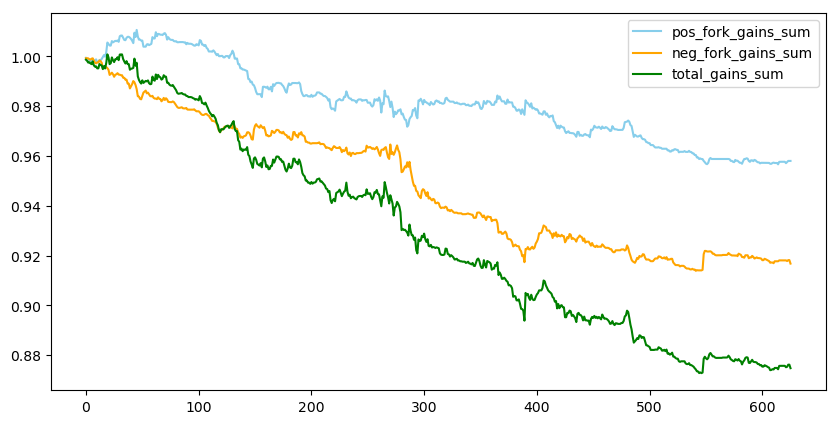

In [49]:
plt.figure(figsize=(10, 5), dpi=100)

pos_fork_pnl.plot(color='skyblue')
neg_fork_pnl.plot(color='orange')
fork_pnl.plot(color='green')

plt.legend()
# plt.title('Tipless Filter, Having Fees')

+ Win Rate

In [50]:
def cal_win_rate(_trading_log):
    daily_pos_fork_winrate = []
    daily_neg_fork_winrate = []

    pos_win = []
    pos_lose = []
    neg_win = []
    neg_lose = []

    for i in range(_trading_log.shape[0]):
        if _trading_log['pos_fork_gains'][i].shape[0]:
            _slice = _trading_log['pos_fork_gains'][i]
            daily_pos_fork_winrate.append(len(_slice.loc[_slice>0])/len(_slice))
            pos_win += list(_slice.loc[_slice>0])
            pos_lose += list(_slice.loc[_slice<0])
            
        if _trading_log['neg_fork_gains'][i].shape[0]:
            _slice = _trading_log['neg_fork_gains'][i]
            daily_neg_fork_winrate.append(len(_slice.loc[_slice>0])/len(_slice))
            neg_win += list(_slice.loc[_slice>0])
            neg_lose += list(_slice.loc[_slice<0])

    return daily_pos_fork_winrate, daily_neg_fork_winrate, (pos_win, pos_lose), (neg_win, neg_lose)

In [51]:
dpw, dnw, tpwl, tnwl = cal_win_rate(tmp_t_log)

In [52]:
print(f'Pos Fork Win Rate: {round(len(tpwl[0])/(len(tpwl[0])+len(tpwl[1])), 4)}')
print(f'Pos Fork Win-Loss Ratio: {round(np.abs(sum(tpwl[0]) / sum(tpwl[1])), 4)}\n')

print(f'Neg Fork Win Rate: {round(len(tnwl[0])/(len(tnwl[0])+len(tnwl[1])), 4)}')
print(f'Neg Fork Win-Loss Ratio: {round(np.abs(sum(tnwl[0]) / sum(tnwl[1])), 4)}\n')

print(f'Total Win Rate: {round((len(tpwl[0])+len(tnwl[0]))/(len(tpwl[0])+len(tpwl[1]) + len(tnwl[0])+len(tnwl[1])), 4)}')
print(f'Total Win-Loss Ratio: {round(np.abs((sum(tpwl[0]) + sum(tnwl[0]))/(sum(tpwl[1]) + sum(tnwl[1]))), 4)}')

Pos Fork Win Rate: 0.3974
Pos Fork Win-Loss Ratio: 0.8673

Neg Fork Win Rate: 0.3881
Neg Fork Win-Loss Ratio: 0.7502

Total Win Rate: 0.3927
Total Win-Loss Ratio: 0.8073


Text(0.5,1,'Neg Fork Win Rate')

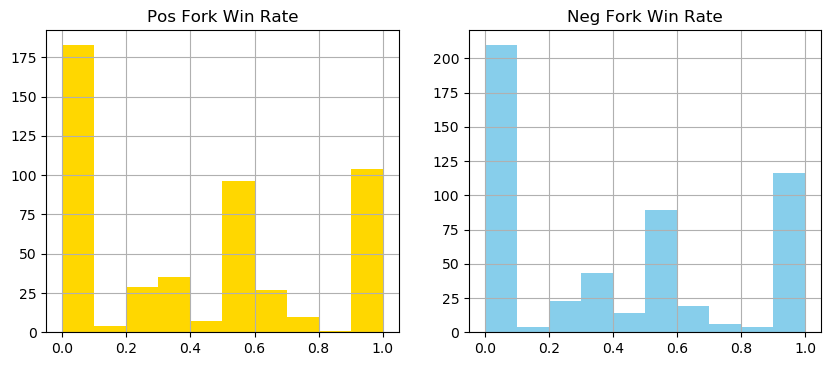

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=100)
pd.Series(dpw).hist(ax=axes[0], color='gold')
axes[0].set_title('Pos Fork Win Rate')
pd.Series(dnw).hist(ax=axes[1], color='skyblue')
axes[1].set_title('Neg Fork Win Rate')
# plt.suptitle('Having Filter, Having Fees')

In [36]:
def profitable_analysis(_pnl):
    Annual_r = (_pnl.diff()/_pnl.shift(1)).mean()*252
    Std = (_pnl.diff()/_pnl.shift(1)).std()*np.sqrt(252)
    Sharpe = Annual_r / Std
    MaxDrawdown = (1 - _pnl/pd.Series(list(_pnl.rolling(len(_pnl)))).apply(lambda x: x.max())).max()
    Calmar = Annual_r / MaxDrawdown
    return Annual_r, Std, Sharpe, MaxDrawdown, Calmar

In [37]:
profitable_analysis(fork_pnl)

(-0.05308810410694705,
 0.023980776717353616,
 -2.21377750740367,
 0.12787400587146813,
 -0.4151594668920302)

#### Plot and Analysis

+ Plot basic and calculated features of one single trading day.
+ Subplot 0: basic information including *Candle bars* and *Positions* (containing reasons why positions are closed)
+ Subplot 1: features related to signal 1 including *P_S_MA*, *P_L_MA*, *CLOSE*, and *Signal1*
+ Subplot 2: features related to signal 2 including *Volume*, *V_L_MA*, *V_S_MA* and *Signal2*
+ Subplot 3: features related to signal 3 including *DIF*, *DEA*, *Close* and *Signal3*
+ Subplot 4: features related to Fluctuations including *H_max*, *L_min*, *Fluct* and *FLUCT_TS*


In [1]:
def plot_all(smp):
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(20, 15), dpi=200)

    ## SUBPLOT 0: Candle bars & Position
    axes[0].set_title('Candle bars & Position')
    axes[0].grid(False)
    axes[0].yaxis.set_ticks_position('left')

    sdf = pd.DataFrame()
    sdf['CLOCK'] = smp['CLOCK'].apply(lambda x: pd.to_datetime(x))
    sdf = sdf.set_index('CLOCK')
    sdf['Open'] = smp['OPEN']
    sdf['Close'] = smp['CLOSE']
    sdf['High'] = smp['HIGH']
    sdf['Low'] = smp['LOW']
    sdf['Volume'] = smp['VOLUME']

    mc = mpf.make_marketcolors(up='red', down='green', edge='black')
    s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc, y_on_right=False)
    
    mpf.plot(sdf, ax = axes[0], type='candle', style = s, ylabel='')

    ax_twin0 = axes[0].twinx()
    ax_twin0.grid(False)
    ax_twin0.yaxis.set_ticks_position('right')

    ax_twin0.bar(smp['CLOCK'].to_list(), smp['Position'], color='pink', alpha=0.6, label='Position')
    Close_Reasons = ['day out', 'macd reverse', 'low fluct', 'vol_mom', 'profit cut', 'loss cut']
    for i in range(6):
        smp['close'] = np.zeros(smp.shape[0])
        smp['close'].loc[smp['close_reason']==i+1] = smp['Position'].loc[smp['close_reason']==i+1] 
        ax_twin0.bar(smp['CLOCK'].to_list(), smp['close'], color=COLORS[i], alpha=0.6, label=f'{Close_Reasons[i]}')

    ax_twin0.set_ylim(-1.0, 1.0)
    ax_twin0.legend(loc='center right')

    ## SUBPLOT 1: P_S_MA & P_L_MA & Close & Signal 1
    axes[1].set_title('Signal 1')
    axes[1].grid(False)
    axes[1].yaxis.set_ticks_position('left')

    smp['CLOSE'].plot(ax=axes[1], color='b')
    smp['P_S_MA'].plot(ax=axes[1], color='orange')
    smp['P_L_MA'].plot(ax=axes[1], color='g')
    axes[1].legend(loc = 'upper left')

    ax_twin1 = axes[1].twinx()
    ax_twin1.grid(False)
    ax_twin1.yaxis.set_ticks_position('right')

    smp['signal1'].plot(alpha=0.5, ax = ax_twin1, color='skyblue') 
    ax_twin1.set_ylim(-1.0, 1.0)
    ax_twin1.legend(loc='upper right')

    ## SUBPLOT 2: Volume & V_L_MA & V_S_MA & Signal 2
    axes[2].set_title('Signal 2')
    axes[2].grid(False)
    axes[2].yaxis.set_ticks_position('left')

    axes[2].bar(smp['CLOCK'].to_list(), smp['VOLUME'], color='purple', alpha=0.3, label='Volume')
    smp['V_S_MA'].plot(ax=axes[2], color='orange')
    smp['V_L_MA'].plot(ax=axes[2], color='g')
    axes[2].legend(loc = 'upper left')

    ax_twin2 = axes[2].twinx()
    ax_twin2.grid(False)
    ax_twin2.yaxis.set_ticks_position('right')

    smp['signal2'].plot(alpha=0.5, ax = ax_twin2, color='skyblue')
    ax_twin2.set_ylim(-1.0, 1.0)
    ax_twin2.legend(loc='upper right')

    ## SUBPLOT 3: DIF & DEA & Close & Signal 3
    axes[3].set_title('Signal 3')
    axes[3].grid(False)
    axes[3].yaxis.set_ticks_position('left')

    smp['DIF'].plot(ax=axes[3], color='orange')
    smp['DEA'].plot(ax=axes[3], color='g')
    axes[3].legend(loc = 'upper left')

    ax_twin3 = axes[3].twinx()
    ax_twin3.grid(False)
    ax_twin3.yaxis.set_ticks_position('right')

    smp['signal3'].plot(alpha=0.5, ax = ax_twin3, color='skyblue')
    ax_twin3.set_ylim(-1.0, 1.0)
    ax_twin3.legend(loc='upper right')

    ## SUBPLOT 4: Fluctuation
    axes[4].set_title('Fluctuation')
    axes[4].grid(False)
    axes[4].yaxis.set_ticks_position('left')

    smp['H_max'].plot(ax=axes[4], color='orange')
    smp['CLOSE'].plot(ax=axes[4], color='b')
    smp['L_min'].plot(ax=axes[4], color='g')
    
    ax_twin4 = axes[4].twinx()
    ax_twin4.grid(False)
    ax_twin4.yaxis.set_ticks_position('right')

    smp['fluct_ts'] = FLUCT_TS
    smp['Fluct'].plot(alpha=0.5, ax = ax_twin4, color='skyblue')
    smp['fluct_ts'].plot(alpha=0.5, ax = ax_twin4, color = 'hotpink')
    ax_twin4.legend(loc='upper right')
    
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

In [3]:
def one_day_micro(_ftmp, _date):
    start_clock = _date + ' 00:00:00'
    end_clock = str(pd.to_datetime(start_clock) + datetime.timedelta(days = 1))
    plot_all(_ftmp.loc[(start_clock < ftmp_p['CLOCK']) & (ftmp_p['CLOCK'] < end_clock)])

In [4]:
one_day_micro(ftmp_p, '2021-12-02')

NameError: name 'ftmp_p' is not defined